In [1]:
fidx = 'irv2_'
midx = '0'

mnames = ['irv2_a1']
weights = [1]

threshold = -1.38
nfold = 5

sub_dir = './sub/'

print(fidx,midx,threshold,nfold)

irv2_ 0 -1.38 5


In [2]:
# results from ens_oof.ipynb
assert(len(mnames)==len(weights))
# mname = 'se_resnext_a2'
# print(mname,mnames,weights)

In [3]:
import numpy as np
import pandas as pd
import pickle
import os
from os import path
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage.transform import resize

from scipy.special import logit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import jaccard_similarity_score, f1_score

import scipy.optimize as opt

import gc
import cv2
from tqdm import tqdm_notebook

from numpy import inf

/home/sasrdw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
name_label_dict = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

In [5]:
test_df = pd.read_csv("sample_submission.csv", index_col="Id")
print(test_df.head())
print(test_df.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [6]:
# test_df["images"] = [np.array(load_img("images/{}.png".format(idx), \
#                                         color_mode = "grayscale")) / 255. \
#                                         # grayscale=True)) / 255. \
#                       for idx in tqdm_notebook(test_df.index)]
# print(test_df.shape)

In [7]:
test_df.columns

Index(['Predicted'], dtype='object')

In [8]:
# save a base copy for reuse below
test_df0 = test_df.copy()


In [9]:
# build submission ensemble as weighted average on logit scale
test_df = test_df0.copy()
idx = test_df.index.values

firstm = True
sumw = 0.

for m in mnames:

    firstf = True
    for fold in range(nfold):
        print('')
        print(m+'_'+str(fold))
        first = True
        nr = 0
        for suffix in ['','a','b','c','d','e','f','g','h','i']:
            fname = sub_dir + m + suffix + '_' + str(fold) + '_bag.pkl'
            if os.path.exists(fname):
                print(fname)
                idb, ptestb = pickle.load(open(fname,'rb'))
                
                ptestb = np.clip(ptestb,-6.0,6.0)
                # ptestb[ptestb==-inf] = -6.0
                # ptestb[ptestb==inf] = 6.0
                
                print(ptestb.min(),ptestb.mean(),ptestb.max())
                
                if first:
                    ptestf = ptestb.copy()
                    idb0 = idb
                    first = False
                else:
                    checki = [i0 != i1 for i0,i1 in zip(idb0,idb)]
                    si = np.array(checki).sum()
                    # print(si)
                    assert si == 0
                    print(np.corrcoef(np.array(ptestf).flatten(),
                                      np.array(ptestb).flatten()))

                    ptestf += ptestb
                nr += 1
                
        ptestf /= nr
        print(ptestf.shape,ptestf.min(),ptestf.mean(),ptestf.max())
                
        if firstf:
            id = idb
            ptest = ptestf.copy()
            firstf = False
        else:
            print(np.corrcoef(np.array(ptest).flatten(),
                              np.array(ptestf).flatten()))
            ptest += ptestf
    
    ptest /= nfold
    pmask = (ptest > threshold).astype(int)
    print(m,nr,ptest.shape,ptest.min(),ptest.mean(),ptest.max(),pmask.mean())
    td = pd.DataFrame({'id':id})
    td[m] = [a for a in ptest]
    td.set_index('id',inplace=True)
    test_df = test_df.join(td)



irv2_a1_0
./sub/irv2_a1_0_bag.pkl
-6.0 -4.769983 6.0
(11702, 28) -6.0 -4.769983 6.0

irv2_a1_1
./sub/irv2_a1_1_bag.pkl
-6.0 -4.7980456 6.0
(11702, 28) -6.0 -4.7980456 6.0
[[1.         0.95866195]
 [0.95866195 1.        ]]

irv2_a1_2
./sub/irv2_a1_2_bag.pkl
-6.0 -4.828511 6.0
(11702, 28) -6.0 -4.828511 6.0
[[1.        0.9606052]
 [0.9606052 1.       ]]

irv2_a1_3
./sub/irv2_a1_3_bag.pkl
-6.0 -4.7985363 6.0
(11702, 28) -6.0 -4.7985363 6.0
[[1.         0.96955865]
 [0.96955865 1.        ]]

irv2_a1_4
./sub/irv2_a1_4_bag.pkl
-6.0 -4.8269677 6.0
(11702, 28) -6.0 -4.8269677 6.0
[[1.         0.96920107]
 [0.96920107 1.        ]]
irv2_a1 1 (11702, 28) -6.0 -4.8044086 6.0 0.0737633371584833


In [10]:
test_df.columns

Index(['Predicted', 'irv2_a1'], dtype='object')

In [11]:
print(idx[:5])

['00008af0-bad0-11e8-b2b8-ac1f6b6435d0'
 '0000a892-bacf-11e8-b2b8-ac1f6b6435d0'
 '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'
 '0008baca-bad7-11e8-b2b9-ac1f6b6435d0'
 '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0']


In [12]:
f = []
clist = list(test_df.columns[1:])
for c in clist:
    f.append(np.array(list(test_df[c])).flatten())
print(clist)
print(np.corrcoef(f))   

['irv2_a1']
1.0


In [13]:
f = []
clist = list(test_df.columns[1:])
for c in clist:
    f.append(np.array(list(test_df[c])))
m = np.array(f)
print(m.shape)

(1, 11702, 28)


In [14]:
weights = np.array(weights)
print(weights)

[1]


In [15]:
ens = np.average(m,axis=0,weights=weights)
print(ens.shape)

(11702, 28)


In [16]:
print(ens[1])

[-2.88022637 -5.46643543 -3.76639509 -2.83490729 -3.72084045  1.27968514
 -3.38922763 -4.88328838 -6.         -6.         -6.         -3.16185689
 -5.042449   -5.20598459 -4.17152071 -5.9331193  -4.37042809 -5.89381695
 -4.61263371 -3.65685129 -5.99142742 -3.26823926 -4.82974148 -3.86653185
 -3.57162809 -1.27207494 -5.32216024 -6.        ]


In [17]:
# fname = 'mthresh.pkl'
# if os.path.isfile(fname): mthresh = pickle.load(open(fname,'rb'))
# mthresh[mname]

In [18]:
# desired class proportions from lb probing
eps = 0.004
desired = {
0 : 0.36239782,
1 : 0.043841336,
2 : 0.075268817,
3 : 0.059322034,
4 : 0.075268817,
5 : 0.075268817,
6 : 0.043841336,
7 : 0.075268817,
8 : eps,
9 : eps,
10 : eps,
11 : 0.043841336,
12 : 0.043841336,
13 : 0.014198783,
14 : 0.043841336,
15 : eps,
16 : 0.028806584,
17 : 0.014198783,
18 : 0.028806584,
19 : 0.059322034,
20 : eps,
21 : 0.126126126,
22 : 0.028806584,
23 : 0.075268817,
24 : eps,
25 : 0.222493888,
26 : 0.028806584,
27 : eps
}
print(desired)

{0: 0.36239782, 1: 0.043841336, 2: 0.075268817, 3: 0.059322034, 4: 0.075268817, 5: 0.075268817, 6: 0.043841336, 7: 0.075268817, 8: 0.004, 9: 0.004, 10: 0.004, 11: 0.043841336, 12: 0.043841336, 13: 0.014198783, 14: 0.043841336, 15: 0.004, 16: 0.028806584, 17: 0.014198783, 18: 0.028806584, 19: 0.059322034, 20: 0.004, 21: 0.126126126, 22: 0.028806584, 23: 0.075268817, 24: 0.004, 25: 0.222493888, 26: 0.028806584, 27: 0.004}


In [19]:
# fixed global threshold
threshold = -2
pred = (ens > threshold).astype(int)
print('fixed threshold',threshold)
for j in range(pred.shape[1]):
    prop = np.mean(pred[:,j])
    print(j,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j],)

fixed threshold -2
0 0.3624 0.5777 Nucleoplasm
1 0.0438 0.0420 Nuclear membrane
2 0.0753 0.1672 Nucleoli
3 0.0593 0.0462 Nucleoli fibrillar center
4 0.0753 0.0496 Nuclear speckles
5 0.0753 0.1019 Nuclear bodies
6 0.0438 0.0417 Endoplasmic reticulum
7 0.0753 0.1199 Golgi apparatus
8 0.0040 0.0016 Peroxisomes
9 0.0040 0.0012 Endosomes
10 0.0040 0.0007 Lysosomes
11 0.0438 0.0469 Intermediate filaments
12 0.0438 0.0276 Actin filaments
13 0.0142 0.0190 Focal adhesion sites
14 0.0438 0.0602 Microtubules
15 0.0040 0.0000 Microtubule ends
16 0.0288 0.0288 Cytokinetic bridge
17 0.0142 0.0253 Mitotic spindle
18 0.0288 0.0589 Microtubule organizing center
19 0.0593 0.0682 Centrosome
20 0.0040 0.0058 Lipid droplets
21 0.1261 0.3367 Plasma membrane
22 0.0288 0.0318 Cell junctions
23 0.0753 0.1184 Mitochondria
24 0.0040 0.0127 Aggresome
25 0.2225 0.5638 Cytosol
26 0.0288 0.0152 Cytoplasmic bodies
27 0.0040 0.0000 Rods & rings


In [20]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]

from scipy.special import expit

def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

pred_t = expit(ens)
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
np.set_printoptions(precision=3, suppress=True, linewidth=100)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))
pred = (pred_t > th_t).astype(int)

Thresholds:  [0.634 0.13  0.589 0.107 0.1   0.194 0.126 0.27  0.1   0.1   0.1   0.15  0.1   0.189 0.324 0.1
 0.135 0.207 0.257 0.163 0.117 0.541 0.151 0.323 0.21  0.539 0.1   0.1  ]
Fractions:  [0.363 0.041 0.076 0.049 0.054 0.073 0.039 0.075 0.002 0.002 0.001 0.042 0.032 0.014 0.043 0.
 0.024 0.013 0.029 0.058 0.006 0.126 0.027 0.075 0.01  0.223 0.017 0.   ]
Fractions (th = 0.5):  [0.408 0.028 0.083 0.021 0.028 0.041 0.012 0.054 0.    0.    0.    0.024 0.012 0.007 0.037 0.
 0.    0.003 0.009 0.024 0.001 0.138 0.011 0.059 0.007 0.249 0.005 0.   ]


In [21]:
# custom thresholds to match lb proportions
thresholds = np.linspace(5, -5, 101)
pred = ens.copy()
for j in range(pred.shape[1]):
    for t in thresholds:
        pred[:,j] = (ens[:,j] > t).astype(int)
        prop = np.mean(pred[:,j])
        if prop >= desired[j]: break
    print(j,'%3.1f' % t,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j],)

0 0.5 0.3624 0.3675 Nucleoplasm
1 -2.2 0.0438 0.0443 Nuclear membrane
2 0.3 0.0753 0.0768 Nucleoli
3 -2.5 0.0593 0.0611 Nucleoli fibrillar center
4 -2.9 0.0753 0.0788 Nuclear speckles
5 -1.5 0.0753 0.0764 Nuclear bodies
6 -2.1 0.0438 0.0441 Endoplasmic reticulum
7 -1.1 0.0753 0.0777 Golgi apparatus
8 -3.0 0.0040 0.0040 Peroxisomes
9 -3.1 0.0040 0.0043 Endosomes
10 -3.6 0.0040 0.0040 Lysosomes
11 -1.9 0.0438 0.0448 Intermediate filaments
12 -2.8 0.0438 0.0459 Actin filaments
13 -1.6 0.0142 0.0147 Focal adhesion sites
14 -0.8 0.0438 0.0444 Microtubules
15 -4.4 0.0040 0.0047 Microtubule ends
16 -2.1 0.0288 0.0320 Cytokinetic bridge
17 -1.5 0.0142 0.0166 Mitotic spindle
18 -1.1 0.0288 0.0297 Microtubule organizing center
19 -1.8 0.0593 0.0619 Centrosome
20 -1.6 0.0040 0.0042 Lipid droplets
21 0.1 0.1261 0.1317 Plasma membrane
22 -1.9 0.0288 0.0303 Cell junctions
23 -0.8 0.0753 0.0764 Mitochondria
24 1.5 0.0040 0.0040 Aggresome
25 0.1 0.2225 0.2314 Cytosol
26 -3.0 0.0288 0.0303 Cytoplasmic 

In [22]:
np.set_printoptions(linewidth=100)
print(pred[:5].astype(int))

[[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]


In [23]:
xps = np.sum(pred,axis=1)
print(xps.shape)
print(xps.min(),xps.mean(),xps.max())

(11702,)
0.0 1.6451034011280123 6.0


In [24]:
print(sum(xps==0)/pred.shape[0])

0.03717313279781234


In [25]:
subs = []
ids = []
for i,fid in enumerate(test_df.index.values):
    subrow = ' '.join(list([str(i) for i in np.nonzero(pred[i])[0]]))
    subs.append(subrow)
    ids.append(fid)
    if i % 1000 == 0: print(i,fid,subrow)
print({'ids':ids[:10], 'subs':subs[:10]})
print(len(ids), len(subs))

0 00008af0-bad0-11e8-b2b8-ac1f6b6435d0 2
1000 15efe29e-bad4-11e8-b2b8-ac1f6b6435d0 26
2000 2bd51caa-bad9-11e8-b2b9-ac1f6b6435d0 24
3000 42f7f174-bace-11e8-b2b8-ac1f6b6435d0 0
4000 589b3070-bad0-11e8-b2b8-ac1f6b6435d0 3
5000 6dd7e7b6-bac7-11e8-b2b7-ac1f6b6435d0 25
6000 835f7a30-bad7-11e8-b2b9-ac1f6b6435d0 2 23
7000 9932fa46-bac6-11e8-b2b7-ac1f6b6435d0 21
8000 aeabe93c-bacb-11e8-b2b8-ac1f6b6435d0 1 5
9000 c4ad1a3a-bada-11e8-b2b9-ac1f6b6435d0 11
10000 da851aec-bada-11e8-b2b9-ac1f6b6435d0 0 25
11000 f071ee12-bad9-11e8-b2b9-ac1f6b6435d0 12 21
{'ids': ['00008af0-bad0-11e8-b2b8-ac1f6b6435d0', '0000a892-bacf-11e8-b2b8-ac1f6b6435d0', '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0', '0008baca-bad7-11e8-b2b9-ac1f6b6435d0', '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0', '00109f6a-bac8-11e8-b2b7-ac1f6b6435d0', '001765de-bacd-11e8-b2b8-ac1f6b6435d0', '0018641a-bac9-11e8-b2b8-ac1f6b6435d0', '00200f22-bad7-11e8-b2b9-ac1f6b6435d0', '0026f154-bac6-11e8-b2b7-ac1f6b6435d0'], 'subs': ['2', '5', '0 5 25', '0', '23', '4', '

In [26]:
subm = pd.DataFrame.from_dict({'Id':ids, 'Predicted':subs}, orient='index').T
fname = 'sub/' + fidx + midx + '.csv'
subm.to_csv(fname, index=False)
print(fname)

sub/irv2_0.csv


In [27]:
from itertools import chain
from collections import Counter
max_idx = 27
subm['target_list'] = subm['Predicted'].map(lambda x: \
            [int(a) if a != '' else -1 for a in str(x).split(' ')])
subm['target_vec'] = subm['target_list'].map(lambda ck: \
            [i in ck for i in range(max_idx+1)])
all_labels = list(chain.from_iterable(subm['target_list'].values))
c_val = Counter(all_labels)
n_keys = c_val.keys()
max_idx = max(n_keys)
for k,v in name_label_dict.items():
    print(k,v, 'count', c_val[k] if k in c_val else 0,
             'prop', '%6.4f' % (c_val[k]/len(ids) if k in c_val else 0))

0 Nucleoplasm count 4301 prop 0.3675
1 Nuclear membrane count 518 prop 0.0443
2 Nucleoli count 899 prop 0.0768
3 Nucleoli fibrillar center count 715 prop 0.0611
4 Nuclear speckles count 922 prop 0.0788
5 Nuclear bodies count 894 prop 0.0764
6 Endoplasmic reticulum count 516 prop 0.0441
7 Golgi apparatus count 909 prop 0.0777
8 Peroxisomes count 47 prop 0.0040
9 Endosomes count 50 prop 0.0043
10 Lysosomes count 47 prop 0.0040
11 Intermediate filaments count 524 prop 0.0448
12 Actin filaments count 537 prop 0.0459
13 Focal adhesion sites count 172 prop 0.0147
14 Microtubules count 520 prop 0.0444
15 Microtubule ends count 55 prop 0.0047
16 Cytokinetic bridge count 375 prop 0.0320
17 Mitotic spindle count 194 prop 0.0166
18 Microtubule organizing center count 348 prop 0.0297
19 Centrosome count 724 prop 0.0619
20 Lipid droplets count 49 prop 0.0042
21 Plasma membrane count 1541 prop 0.1317
22 Cell junctions count 354 prop 0.0303
23 Mitochondria count 894 prop 0.0764
24 Aggresome count 47 

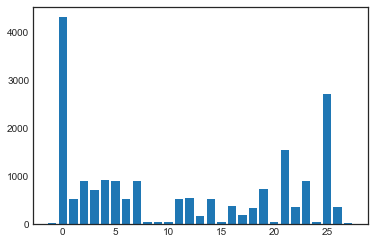

In [28]:
train_sum_vec = np.sum(np.stack(subm['target_vec'].values, 0), 0)
_ = plt.bar(n_keys, [train_sum_vec[k] for k in n_keys])

In [29]:
from sklearn.metrics import f1_score

# compute f1 score between two submission files
def f1_sub(csv0, csv1, num_classes=28):
    c0 = pd.read_csv(csv0)
    c1 = pd.read_csv(csv1)
    assert c0.shape == c1.shape
    s0 = [s if isinstance(s,str) else '' for s in c0.Predicted]
    s1 = [s if isinstance(s,str) else '' for s in c1.Predicted]
    p0 = [s.split() for s in s0]
    p1 = [s.split() for s in s1]
    y0 = np.zeros((c0.shape[0],num_classes)).astype(int)
    y1 = np.zeros((c0.shape[0],num_classes)).astype(int)
    # print(p0[:5])
    for i in range(c0.shape[0]):
        for j in p0[i]: y0[i,int(j)] = 1
        for j in p1[i]: y1[i,int(j)] = 1
    # print(y0[:5])
            
    return f1_score(y0, y1, average='macro')

In [30]:
f1_sub(fname,'sub/protein_classification.csv')

0.6550083147665785

In [31]:
f1_sub(fname,'sub/submit_InceptionV3.csv')

0.584523246664608

In [32]:
f1_sub(fname,'sub/submit_InceptionResNetV2_3.csv')

0.5647341679299881

In [33]:
f1_sub('bojan/submit_InceptionV3.csv','sub/submit_InceptionV3.csv')

0.6432439747575565

In [34]:
f1_sub('bojan/iv3_0.csv','sub/submit_InceptionV3.csv')

0.642000750559354

In [35]:
f1_sub('bojan/inceptionv3_2.csv','sub/submit_InceptionV3.csv')

0.5987392720028134

In [36]:
f1_sub('bojan/inceptionv3_0.csv','bojan/inceptionv3_1.csv')

0.4642857142857143

In [37]:
f1_sub('bojan/inceptionv3_0.csv','bojan/inceptionv3_2.csv')

0.1426221052396753

In [38]:
f1_sub('sub/submit_InceptionResNetV2_3.csv','sub/submit_InceptionV3.csv')

0.5918623923200268

In [39]:
f1_sub('sub/submit_InceptionResNetV2_3.csv','bojan/inceptionresnetv2_1.csv')

0.6575760350950599